## Glacier MB distribution plots inspired by Matthias Huss 
- overall idea: plot specific MB distributions and show that the year (2022) is an extreme melt year. Every vertical line represents the observation of one year
- the original idea is from Matthias Huss, I just replotted it for other glaciers and added some new ideas inside
    - original post from Matthias Huss: https://twitter.com/matthias_huss/status/1575539821493293058



---

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib import cm
import scipy
from scipy.stats import norm
plt.rcParams['savefig.dpi'] = 300
%matplotlib inline

**here we use the data for Hintereisferner and Kesselwandferner:**
- but the code should similarly work for other glaciers (with some tiny manual adjustments)

In [5]:
# load the data
spec_mb = pd.read_csv('spec_mb_hef_kwf_2023.csv', sep=';')
spec_mb.index = spec_mb['calender year']
# check if there are any missing columns and if yes drop them
spec_mb = spec_mb.dropna()

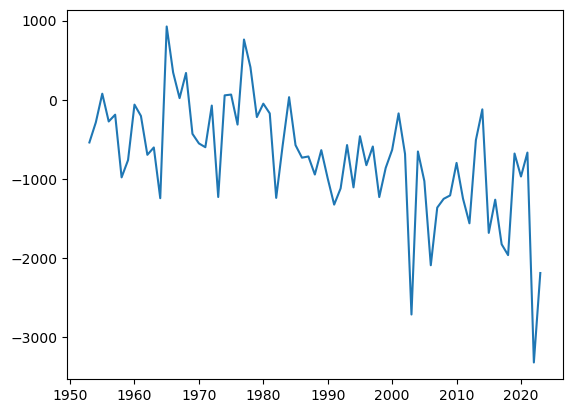

In [13]:
plt.plot(spec_mb.index, spec_mb['HEF mass balance (kg/m-2)'])

In [6]:
spec_mb.loc[spec_mb['HEF mass balance (kg/m-2)']>0]

,hydrological year,calender year,HEF mass balance (kg/m-2),KWF mass balance (kg/m-2)
calender year,,,,
1955,1954/1955,1955,76,246
1965,1964/1965,1965,925,1039
1966,1965/1966,1966,344,594
1967,1966/1967,1967,20,297
1968,1967/1968,1968,338,464
1974,1973/1974,1974,55,573
1975,1974/1975,1975,65,369
1977,1976/1977,1977,760,701
1978,1977/1978,1978,411,422


the last year that had a positive MB for the HEF over the entire time series:

In [7]:
spec_mb.loc[spec_mb['HEF mass balance (kg/m-2)']>0].index.max()

1984

amont of years with positive MB in total: (all before 1984 for HEF)

In [8]:
len(spec_mb.loc[spec_mb['HEF mass balance (kg/m-2)']>0])

10

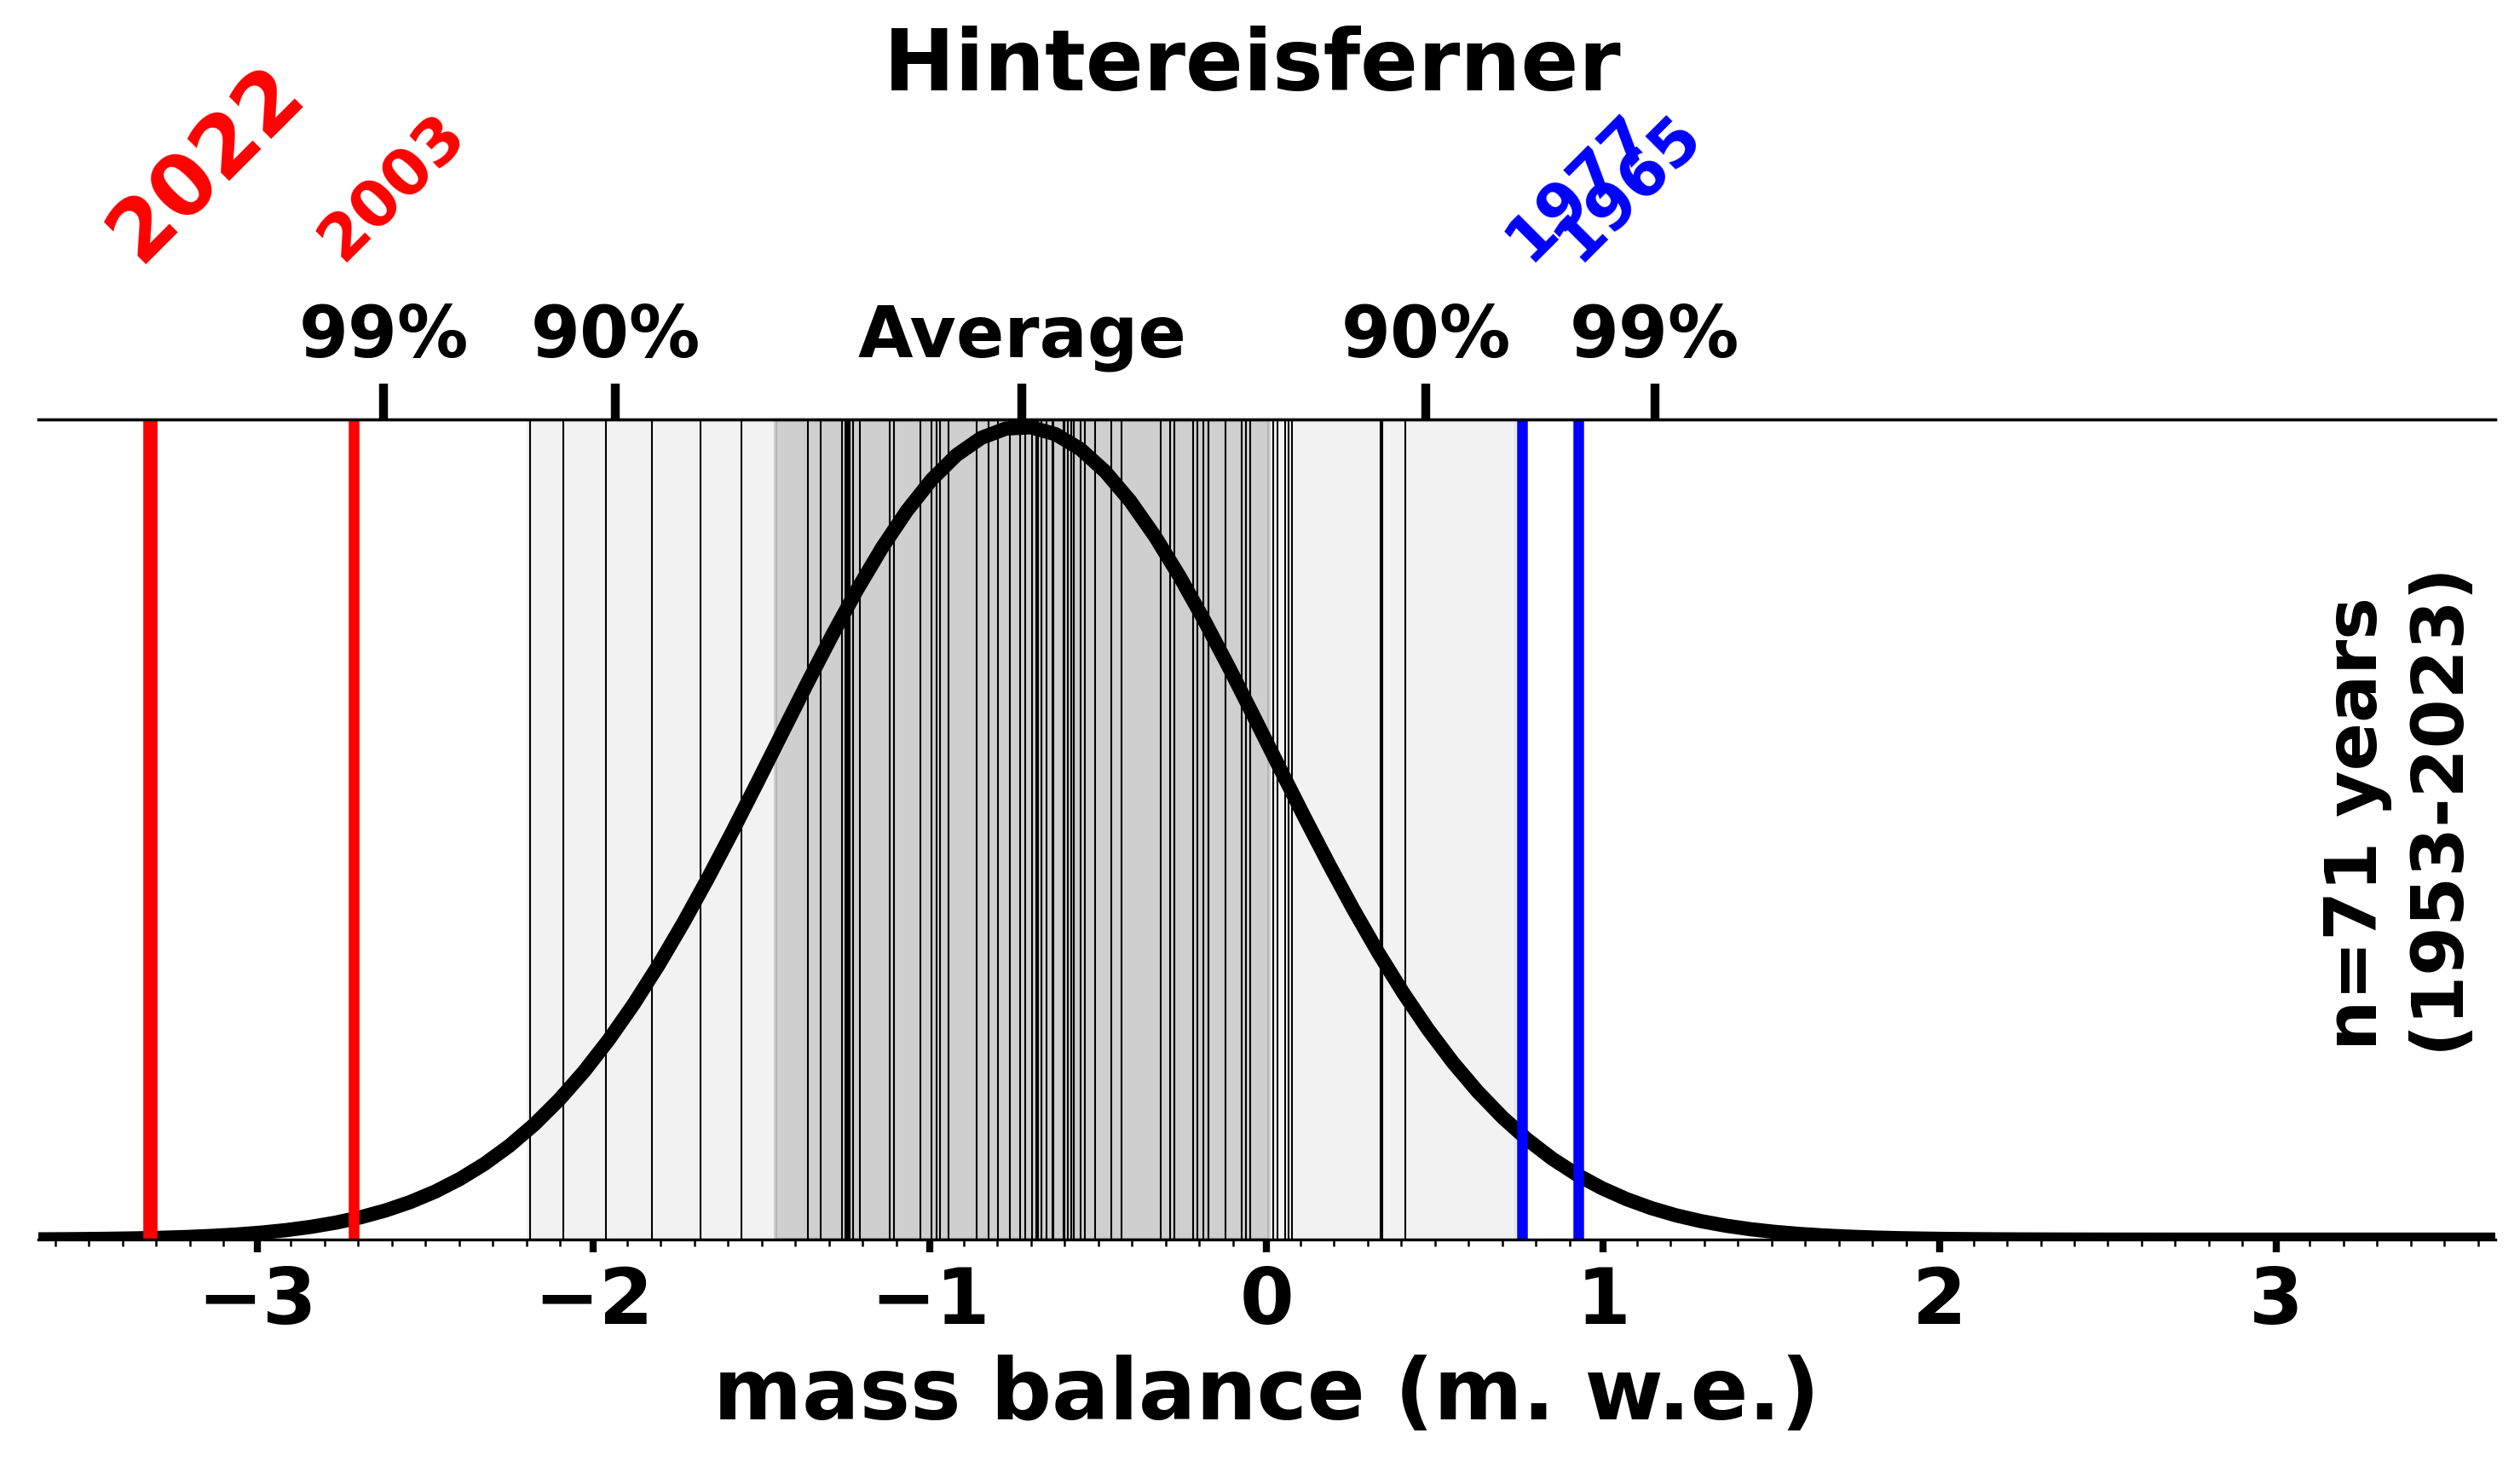

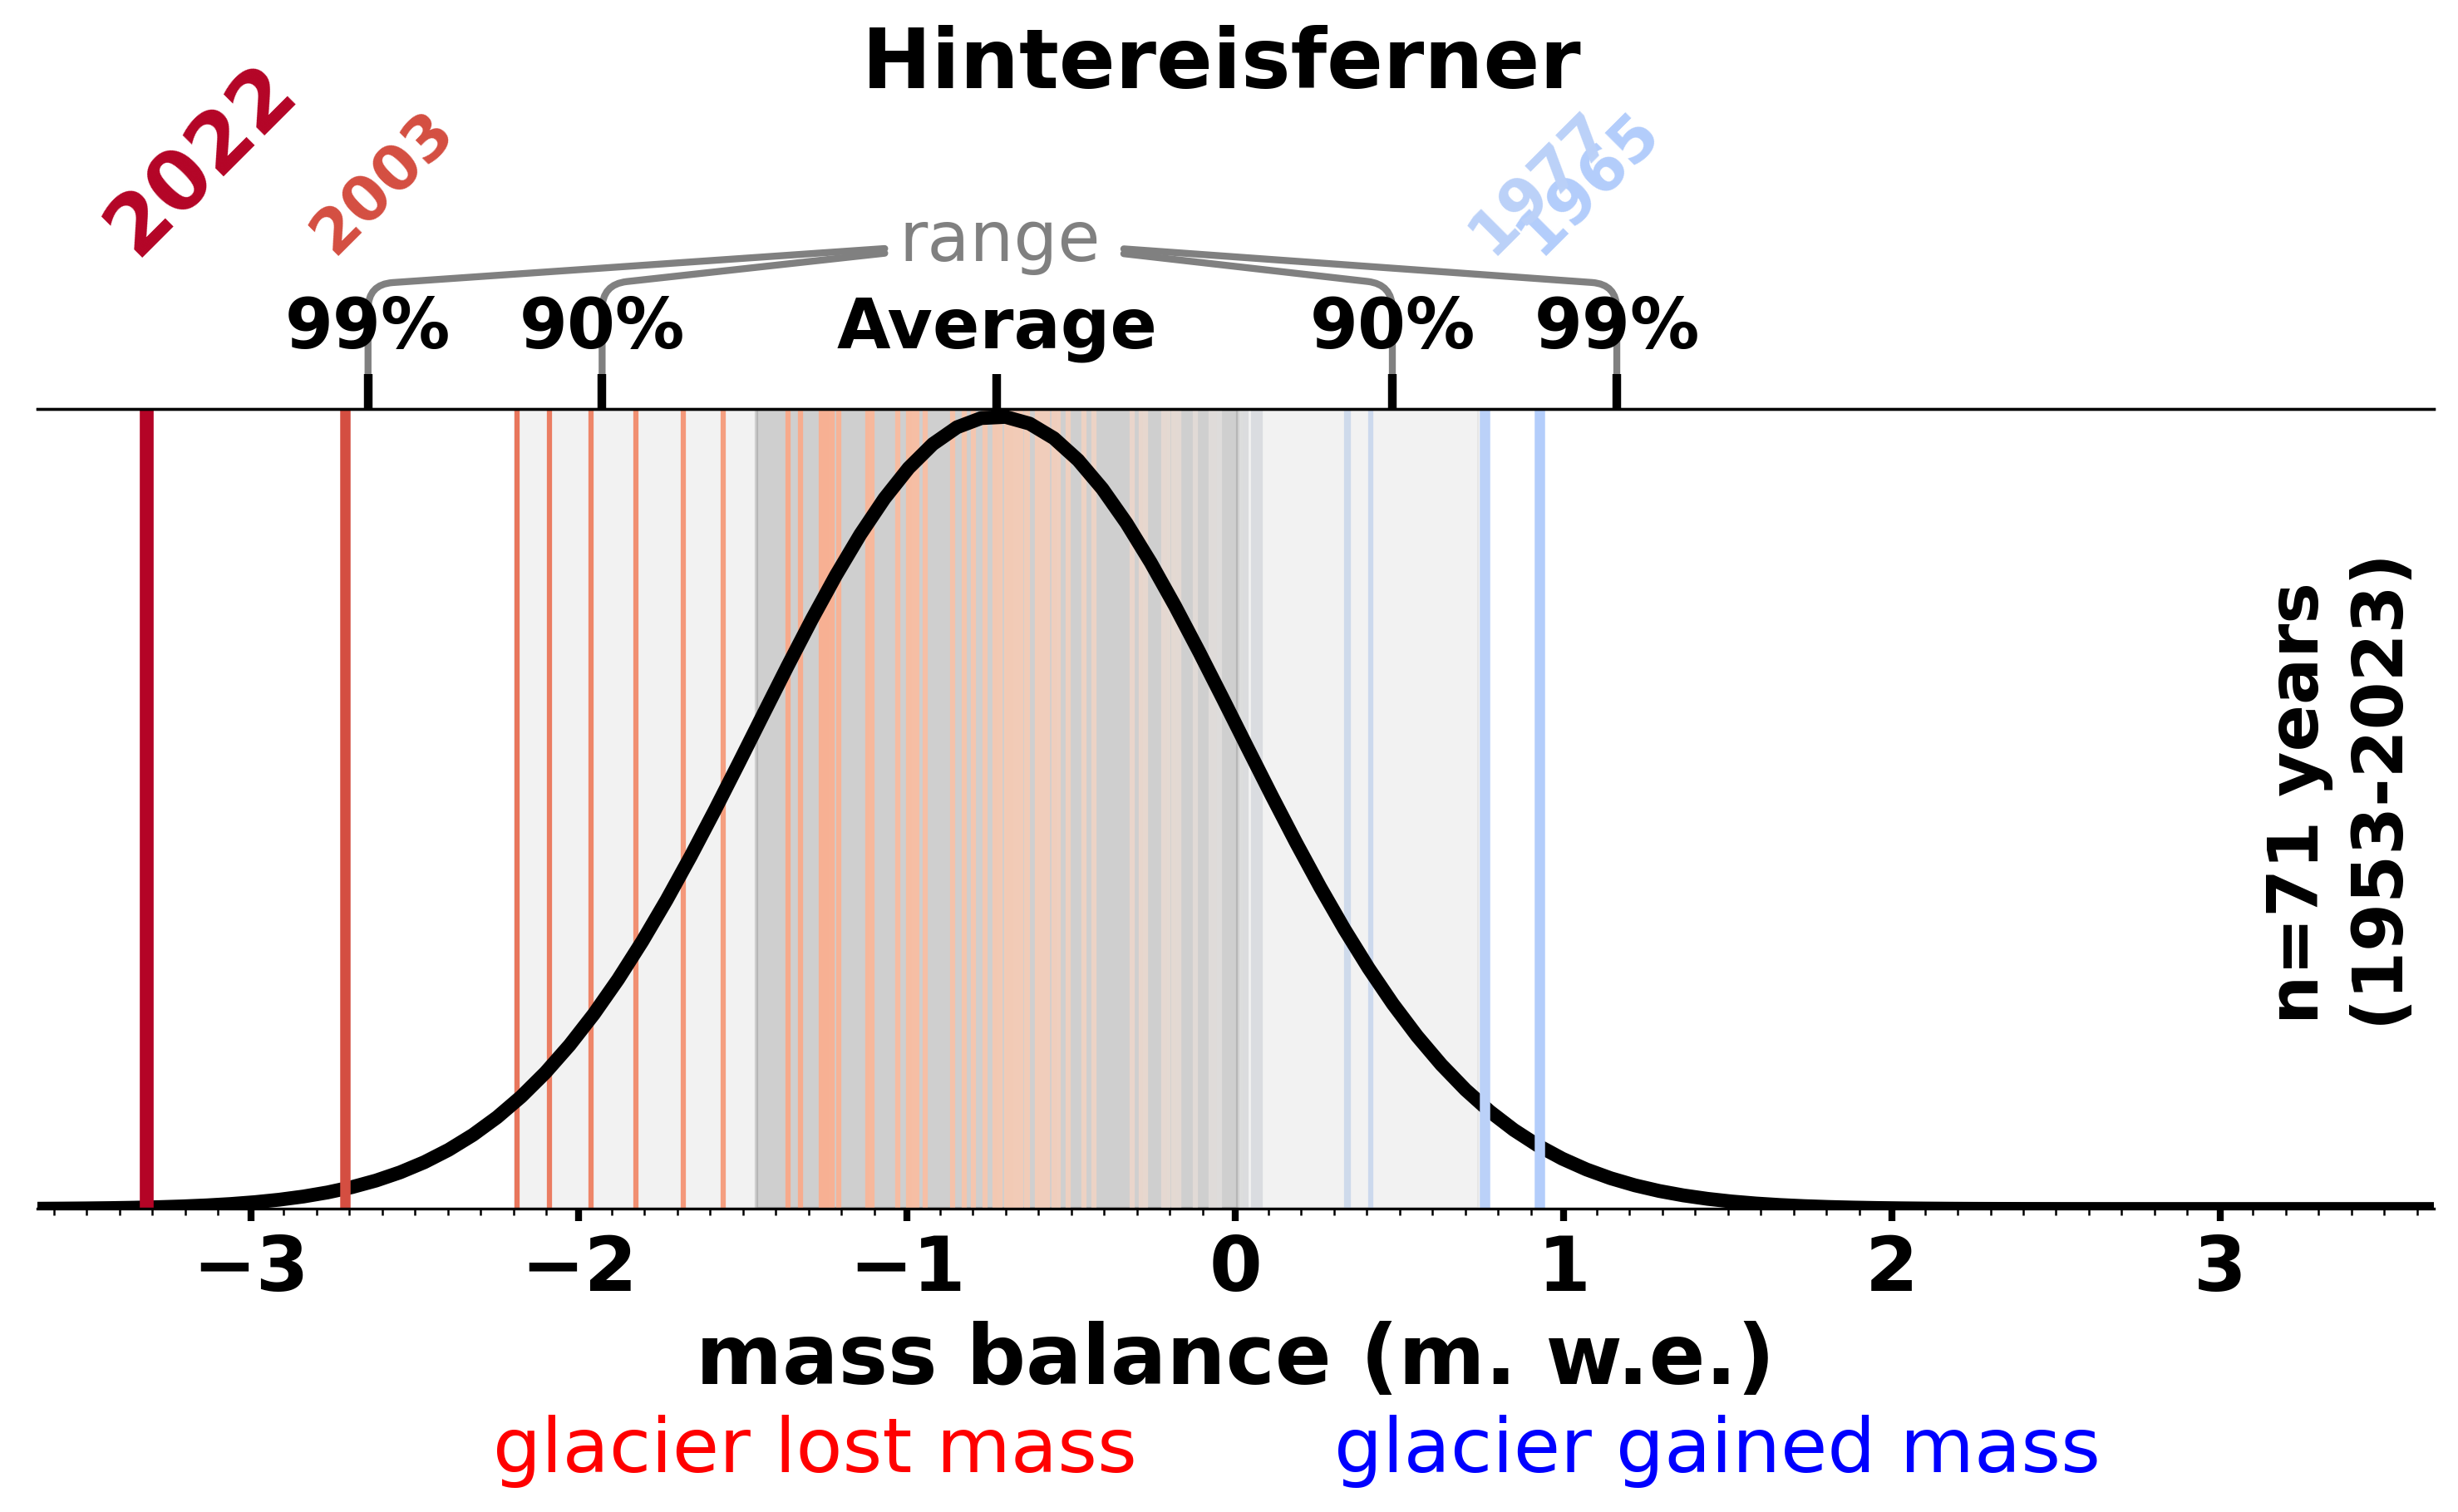

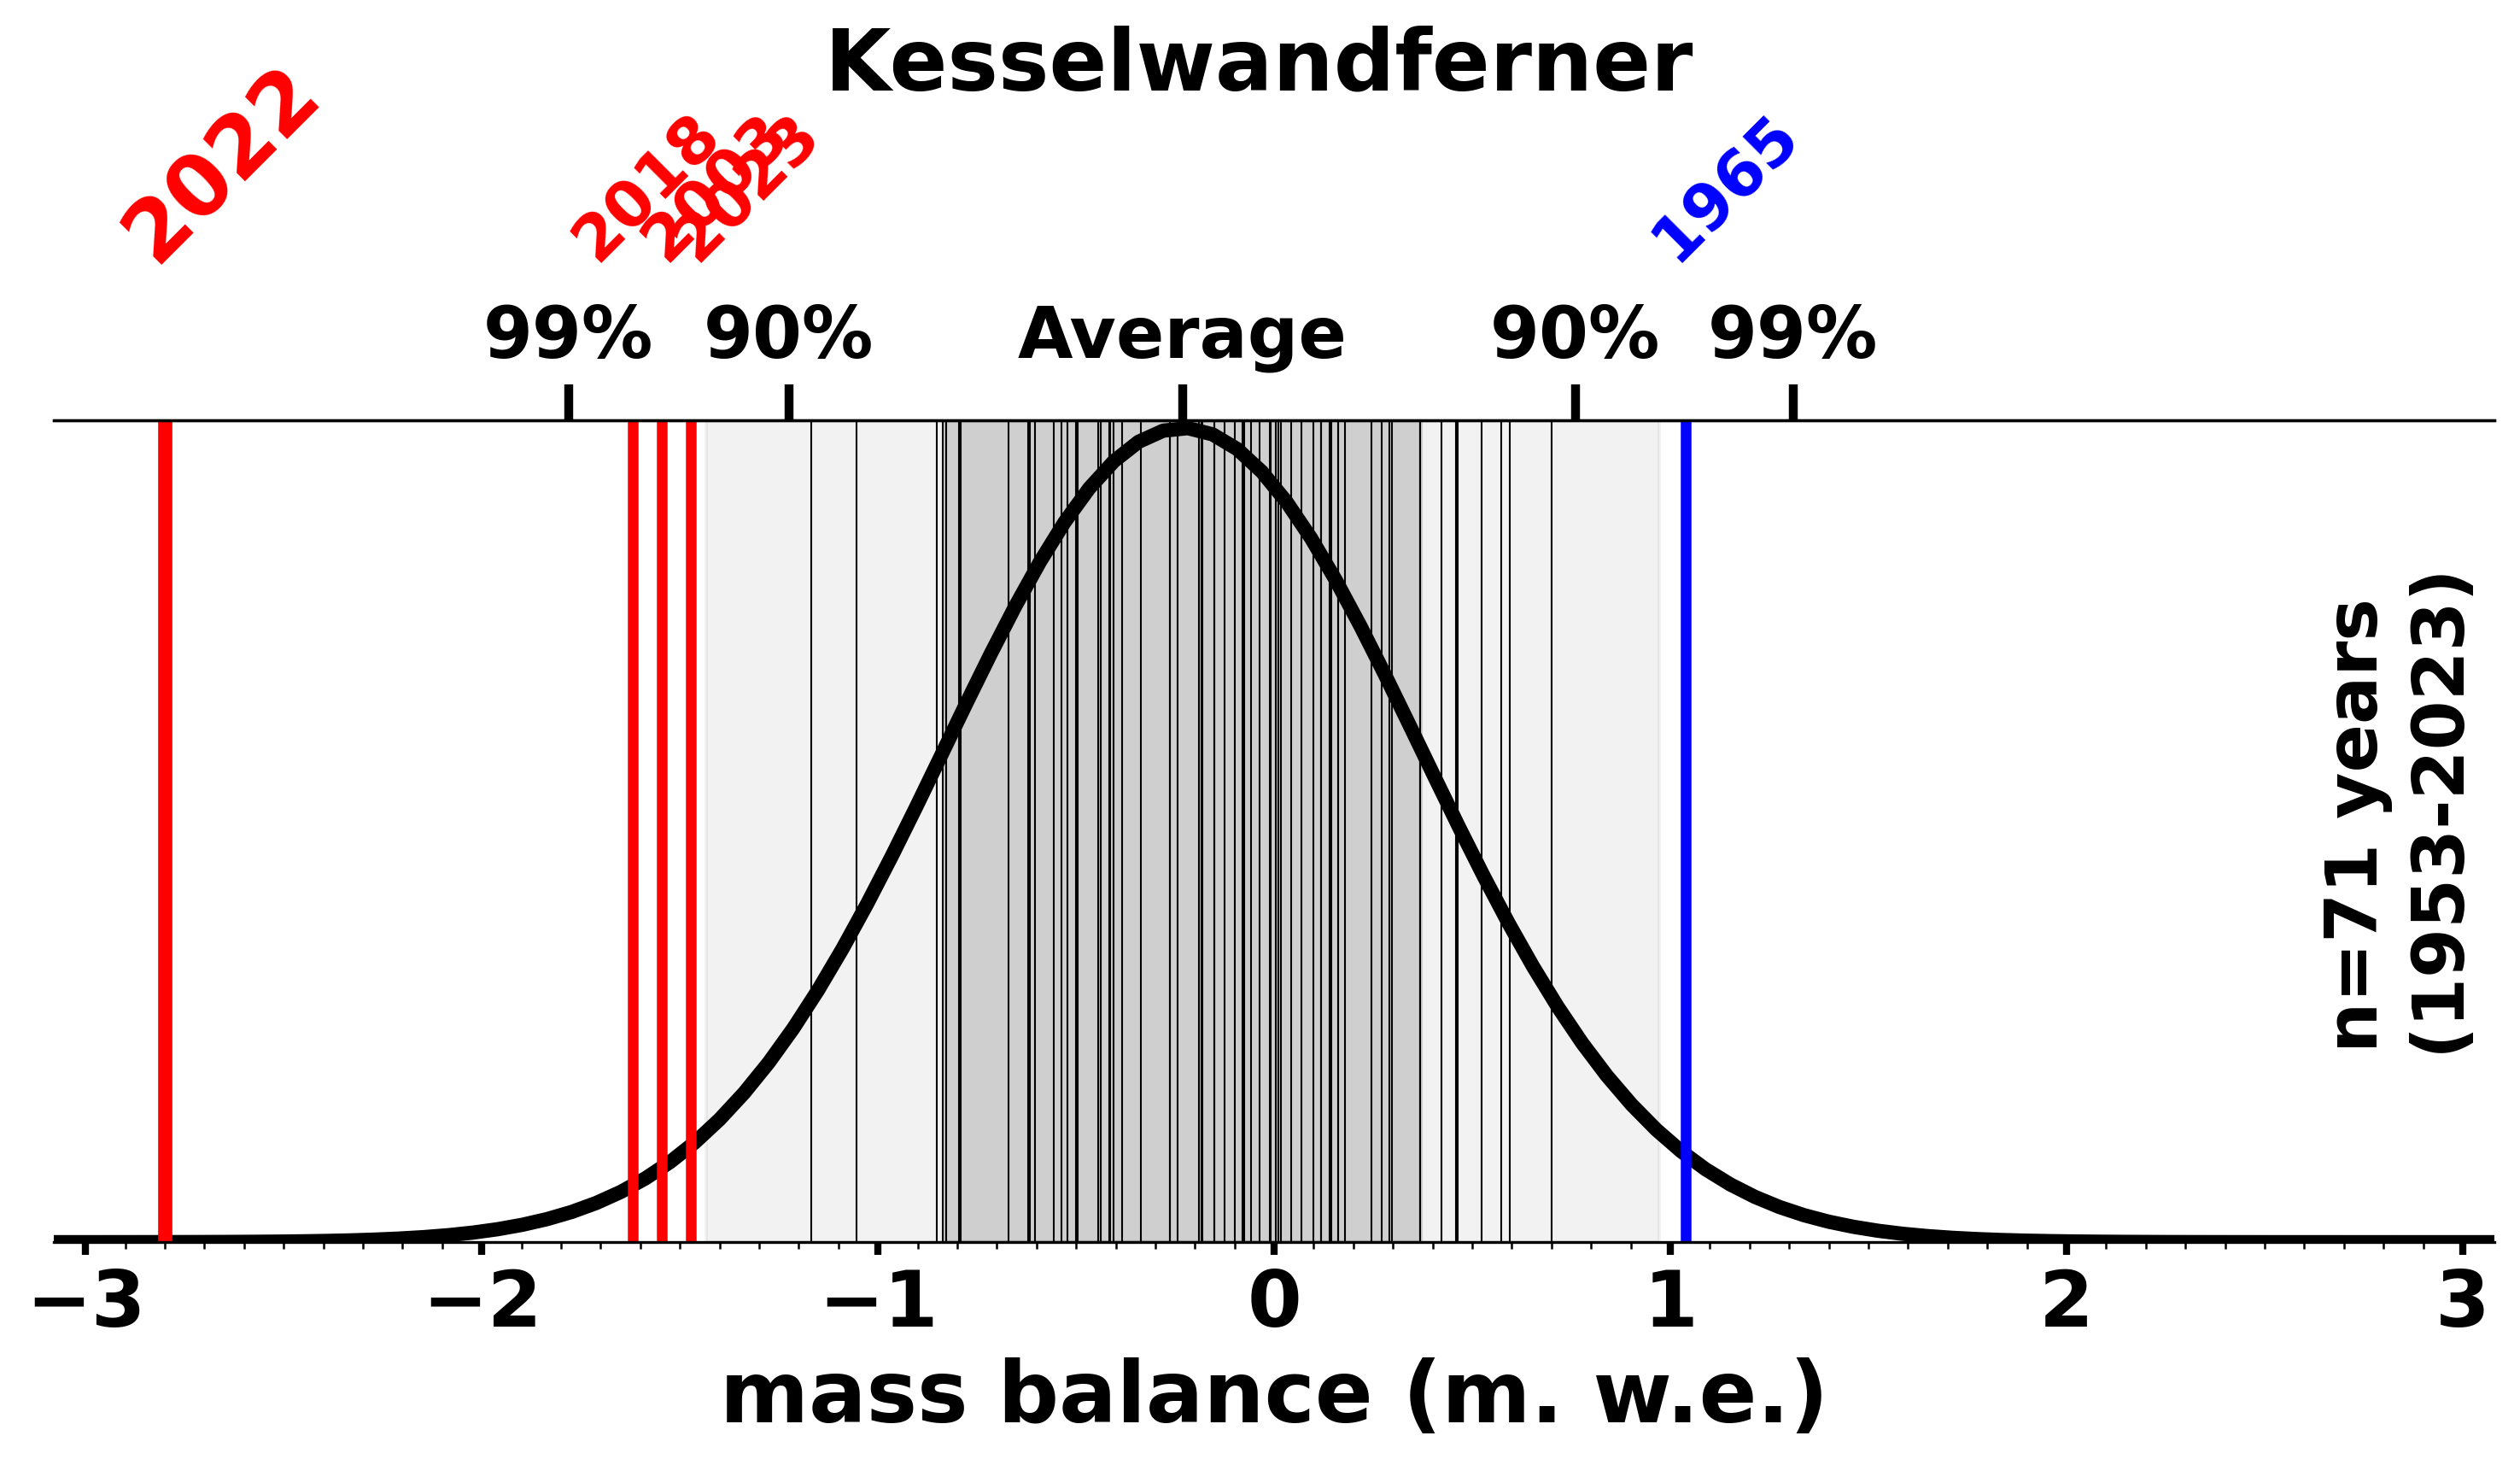

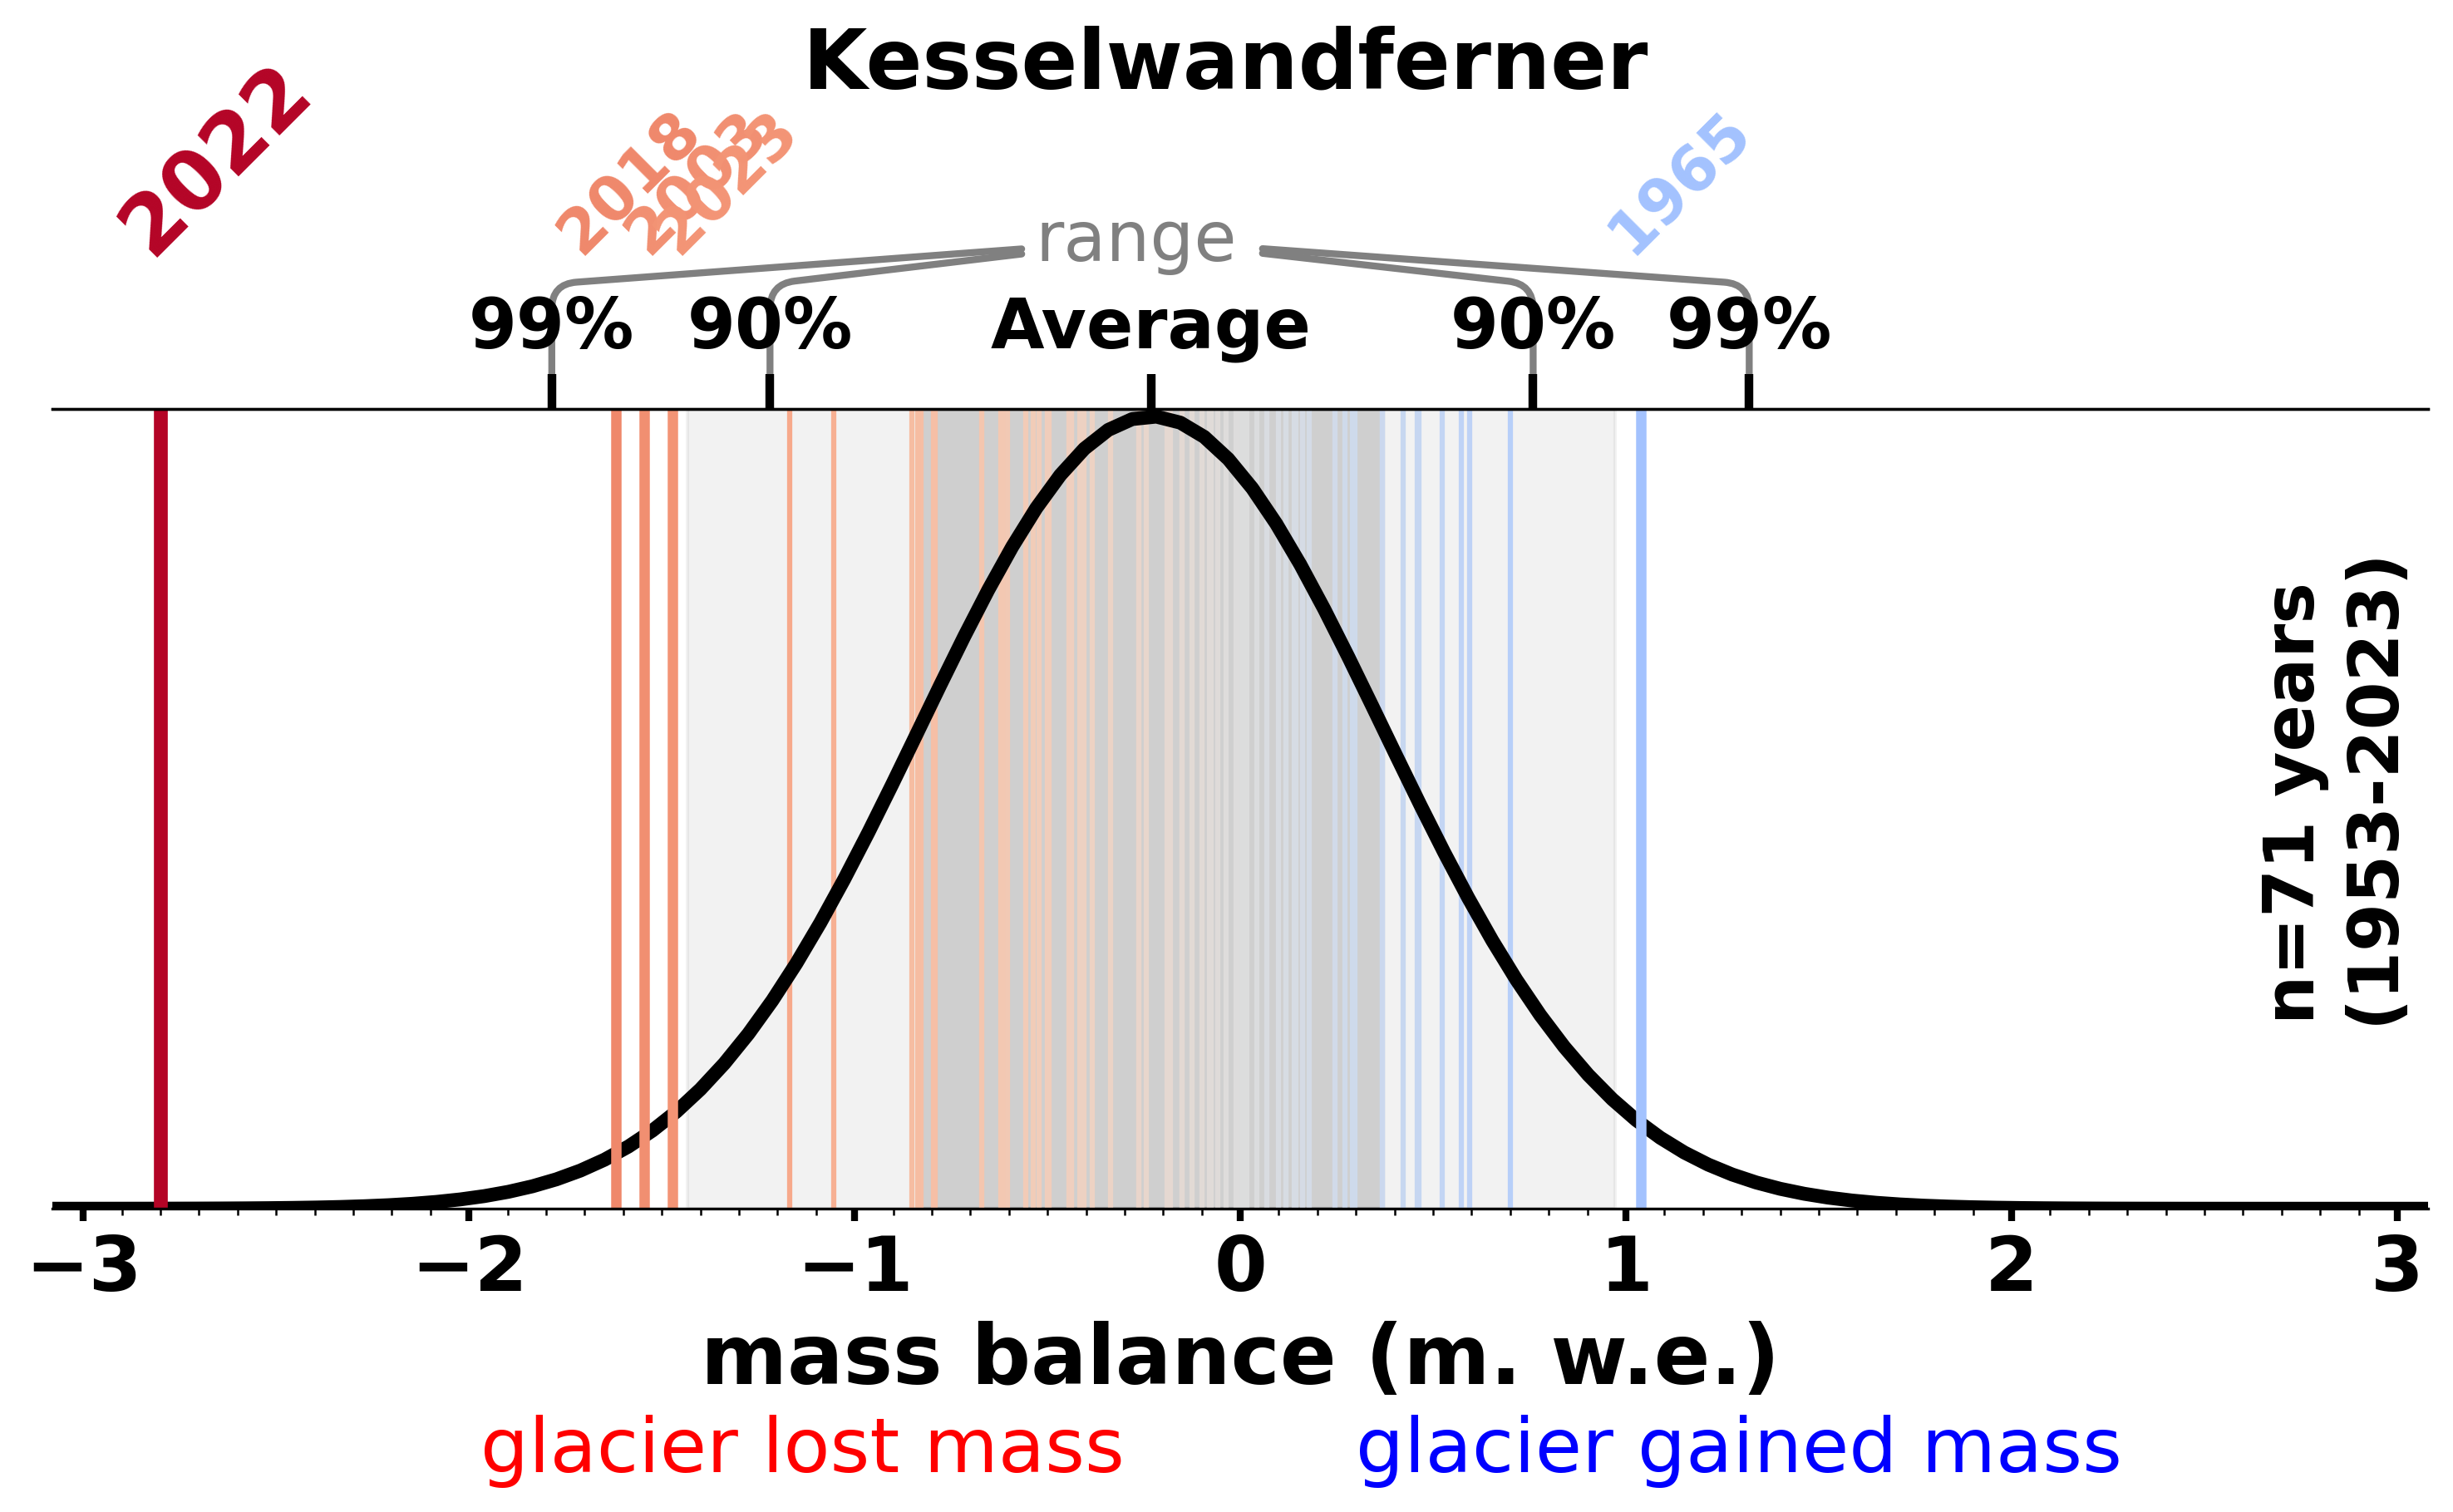

In [16]:
add_range = True
for save in ['save_png', 'save_pdf_svg']:
    # the arrow - line connections to display the ranges somehow work differently if saved as png or as pdf svg, therefore I need different numbers to get "similar" outcomes
    if save == 'save_png':
        armB = 150
    elif save == 'save_pdf_svg':
        armB = 45
    arrowprops = {"arrowstyle":"-", "color":"gray", "connectionstyle":f"arc,angleA=0,angleB=90,armA=0,armB={armB},rad=30", "lw":2}
    for glacier in ['Hintereisferner', 'Kesselwandferner']:
        # the test "glacier lost mass" and "..gained mass", needs different y-location depending on the glacier scale
        # this is adapted here, could be automated if you want to do it on other glaciers ... 
        if glacier == 'Hintereisferner':
            y_span_text_m = 0.18
        elif glacier == 'Kesselwandferner':
            y_span_text_m = 0.22
        for version in ['simple', 'advanced']:
            if glacier == 'Hintereisferner':
                spec_mb_values = spec_mb['HEF mass balance (kg/m-2)']/1000  # convert to m w.e.
            elif glacier == 'Kesselwandferner':
                spec_mb_values = spec_mb['KWF mass balance (kg/m-2)']/1000  # convert to m w.e.

            # get maximum specific mb and use them as limits for the plots and for the colormap scales 
            # we center the mass balance at 0, hence we just get the maximum absolute value 
            xlims_abs = np.max([np.absolute(spec_mb_values.max()),
                    np.absolute(spec_mb_values.min())])*1.1
            if version == 'advanced':
                # for the blue-red colormap (only necessary for advanced version)
                # that is centered at MB = 0
                # normalize item number values to colormap
                # strongest color for the maximum absolute MB
                norm_col = matplotlib.colors.Normalize(vmin=-np.max([np.absolute(spec_mb_values.max()), 
                                                                     np.absolute(spec_mb_values.min())]),
                                                       vmax=np.max([np.absolute(spec_mb_values.max()), 
                                                                    np.absolute(spec_mb_values.min())]))

            fig,_ = plt.subplots(1,1,figsize=(10,6))
            fig.set_dpi(300)

            # plot each year as vertical line 
            for j, yr in enumerate(spec_mb.index):
                if version == 'advanced':
                    color =  cm.coolwarm_r(norm_col(spec_mb_values))[j]
                    lw = 1.5
                else:
                    color = 'black'
                    lw = 0.5
                plt.axvline(spec_mb_values.loc[yr], color = color, lw=lw)

            plt.xlim([-xlims_abs, xlims_abs])

            # fit and plot the gaussian distribution (fitted from the observations)
            # get mean and std of the observed specific mb values
            mean, std = norm.fit(spec_mb_values)
            xmin, xmax = -xlims_abs,xlims_abs
            x = np.linspace(xmin, xmax, 100)
            y = norm.pdf(x, mean, std)
            plt.plot(x, y, lw=4, color='black')

            # check if a year is "extreme" (outside the mean +/- 2std or mean +/- 3 std)
            # if this is true, draw the vertical line bigger and in color (depending on if it is a positive or negative extreme)
            # horizontal displacement of year text
            for j,yr in enumerate(spec_mb.index):
                if glacier == 'Kesselwandferner':
                    if yr==2018:
                        x_ch = 1.11
                    else:
                        x_ch = 1.05
                else:
                    x_ch = 1.05
                if spec_mb_values.loc[yr] < mean-3*std:
                    if version == 'advanced':
                        color = cm.coolwarm_r(norm_col(spec_mb_values))[j]
                    else:
                        color = 'red'
                    ## very negative MB extremes in red
                    plt.axvline(spec_mb_values.loc[yr], color = color, lw=4)
                    plt.text(spec_mb_values.loc[yr]*x_ch,y.max()+y.max()/4.8 ,f'{yr}', 
                             rotation=45, fontsize=24, fontweight='bold', color = color, zorder=2)
                elif spec_mb_values.loc[yr] < mean-2*std:
                    if version == 'advanced':
                        color = cm.coolwarm_r(norm_col(spec_mb_values))[j]
                    else:
                        color = 'red'
                    ## negative MB extremes in red
                    plt.axvline(spec_mb_values.loc[yr], color = color, lw=3)

                    plt.text(spec_mb_values.loc[yr]*x_ch,y.max()+y.max()/4.8 ,f'{yr}', #%': year {spec_mb_values.index[0]}-{spec_mb_values.index[-1]}',
                             rotation=45, 
                             fontsize=18, fontweight='bold', color = color, zorder=2)
                elif spec_mb_values.loc[yr] > mean+2*std:
                    if version == 'advanced':
                        color = cm.coolwarm_r(norm_col(spec_mb_values))[j]
                    else:
                        color = 'blue'
                    ## positive MB extremes 
                    plt.axvline(spec_mb_values.loc[yr], color = color, lw=3)
                    plt.text(spec_mb_values.loc[yr]*0.89,
                             y.max()+y.max()/4.8 ,f'{yr}', 
                             rotation=45, 
                             fontsize=18, fontweight='bold', color = color, zorder=2)
                elif spec_mb_values.loc[yr] > mean+3*std:
                    # does not occur for HEF and KWF, but maybe for other glaciers
                    if version == 'advanced':
                        color = cm.coolwarm_r(norm_col(spec_mb_values))[j]
                    else:
                        color = 'blue'
                    ## positive MB extremes 
                    plt.axvline(spec_mb_values.loc[yr], color = color, lw=4)
                    plt.text(spec_mb_values.loc[yr]*0.89,
                             y.max()+y.max()/4.8 ,f'{yr}', 
                             rotation=45, 
                             fontsize=24, fontweight='bold', color = color, zorder=2)

            plt.xlabel('mass balance (m. w.e.)', fontsize=24, fontweight='bold')
            plt.title(f'{glacier} \n \n', fontsize=24, fontweight='bold')
            ax = plt.gca()
            ax.set_xticks(np.arange(-int(xlims_abs)-1, int(xlims_abs)+1.01,0.1), minor=True)
            plt.xticks(ticks=np.arange(-int(xlims_abs), int(xlims_abs)+0.01,1), fontsize=22, fontweight='bold')#, width=2)
            ax.tick_params(axis='x', which='major', labelsize=22, width=2) #,fontweight='bold') #, width=2.5, length=10)

            plt.xlim([-xlims_abs, xlims_abs])

            plt.text(0.93, 0.25,f'n={len(spec_mb_values)} years\n({spec_mb.index[0]}-{spec_mb.index[-1]})', 
                     rotation=90, transform=plt.gca().transAxes, fontsize=20, fontweight='bold')

            # create secondary axis and plot the quantiles 
            ax2 = ax.secondary_xaxis(location='top')
            # create random values and then compute the quantiles to get the 90% and 99%-range
            gauss_dis_random_vals=np.random.normal(loc=mean, scale=std, size=100000)
            q005,q05,q95,q995 = np.quantile(gauss_dis_random_vals, q=[0.005, 0.05,0.95,0.995])
            ax2.set_xticks([q005,q05,mean,q95,q995])
            ax2.set_xticklabels(labels= ['99%','90%',r'Average','90%','99%'] , fontweight='bold', fontsize=18)
            ax2.set_zorder(2)
            if version=='advanced' and add_range:
                # draw the range line to make clearer that this represents the 99%-range & 90% range ...
                plt.annotate('range', xy=(q05, y.max()*1.01),
                            xytext=(mean-0.3, y.max()*1.18), fontsize=20,color='grey',
                            xycoords='data',
                              verticalalignment='bottom',
                             arrowprops=arrowprops,
                            zorder=1) 
                plt.annotate('range', xy=(q95, y.max()*1.01), alpha=0,
                            xytext=(mean-0.27, y.max()*1.18), fontsize=20, 
                            xycoords='data',
                                                       verticalalignment='bottom',
                             arrowprops=arrowprops,
                            zorder=1) 

                plt.annotate('range', xy=(q005, y.max()*1.01), alpha=0,
                            xytext=(mean-0.3, y.max()*1.18), fontsize=20,color='grey',
                            xycoords='data',
                             verticalalignment='bottom',
                             arrowprops=arrowprops,
                            zorder=1) 
                plt.annotate('range', xy=(q995, y.max()*1.01), alpha=0,
                            xytext=(mean-0.27, y.max()*1.18), fontsize=20, 
                                                       verticalalignment='bottom',
                            xycoords='data',
                             arrowprops= arrowprops,
                            zorder=1) 

            # remove yticks
            plt.yticks(ticks=[])
            #remove yline axis
            ax.spines['left'].set_linewidth(0)
            ax.spines['right'].set_linewidth(0)
            # make sure that 0 "probability" is directly on the x-axis
            plt.ylim([0,y.max()*1.01])

            # make spans over mean +/-1std and mean +/-2std
            plt.axvspan(mean-std, mean+std, color='grey', alpha = 0.3)
            plt.axvspan(mean-2*std, mean+2*std, color='grey', alpha = 0.1)

            #if save=='save_png':
            plt.tight_layout()
            # set the parameters for both axis: label size in font points, the line tick line width and length in pixels
            ax2.tick_params(axis='x', which='major', labelsize=20, width=2.5, length=10)

            if version == 'advanced':
                plt.text(0.3, y.min()-y_span_text_m,'glacier gained mass', color='blue', rotation=0, fontsize=22)
                plt.text(-0.3, y.min()-y_span_text_m,'glacier lost mass', color='red', rotation=0, fontsize=22, 
                         horizontalalignment='right')
            #if save == 'save_pdf_svg':
            #    plt.tight_layout()

            if glacier == 'Hintereisferner':
                if save=='save_png':
                    plt.savefig(f'hef_mb_distributions_{version}.png', bbox_inches='tight')
                else:
                    plt.savefig(f'hef_mb_distributions_{version}.svg', bbox_inches='tight')
                    plt.savefig(f'hef_mb_distributions_{version}.pdf', bbox_inches='tight')

            elif glacier == 'Kesselwandferner':
                if save=='save_png':
                    plt.savefig(f'kwf_mb_distributions_{version}.png', bbox_inches='tight') 
                else:
                    plt.savefig(f'kwf_mb_distributions_{version}.svg', bbox_inches='tight') 
                    plt.savefig(f'kwf_mb_distributions_{version}.pdf', bbox_inches='tight')
            if save == 'save_pdf_svg':
                plt.close()

- in advanced version, the colors go from red (most negative) to blue (most positive), and have a neutral color in mb=0 


### plot variant for Cryosphere Short Communication paper (Voordendag et al., in discussion)

In [8]:
import seaborn as sns
base_col = sns.color_palette([sns.color_palette('colorblind')[0], sns.color_palette('colorblind')[2], sns.color_palette('colorblind')[3]])

col_sp_yr = {2020: base_col[0],
            2021: base_col[1],
            2022: base_col[2]}

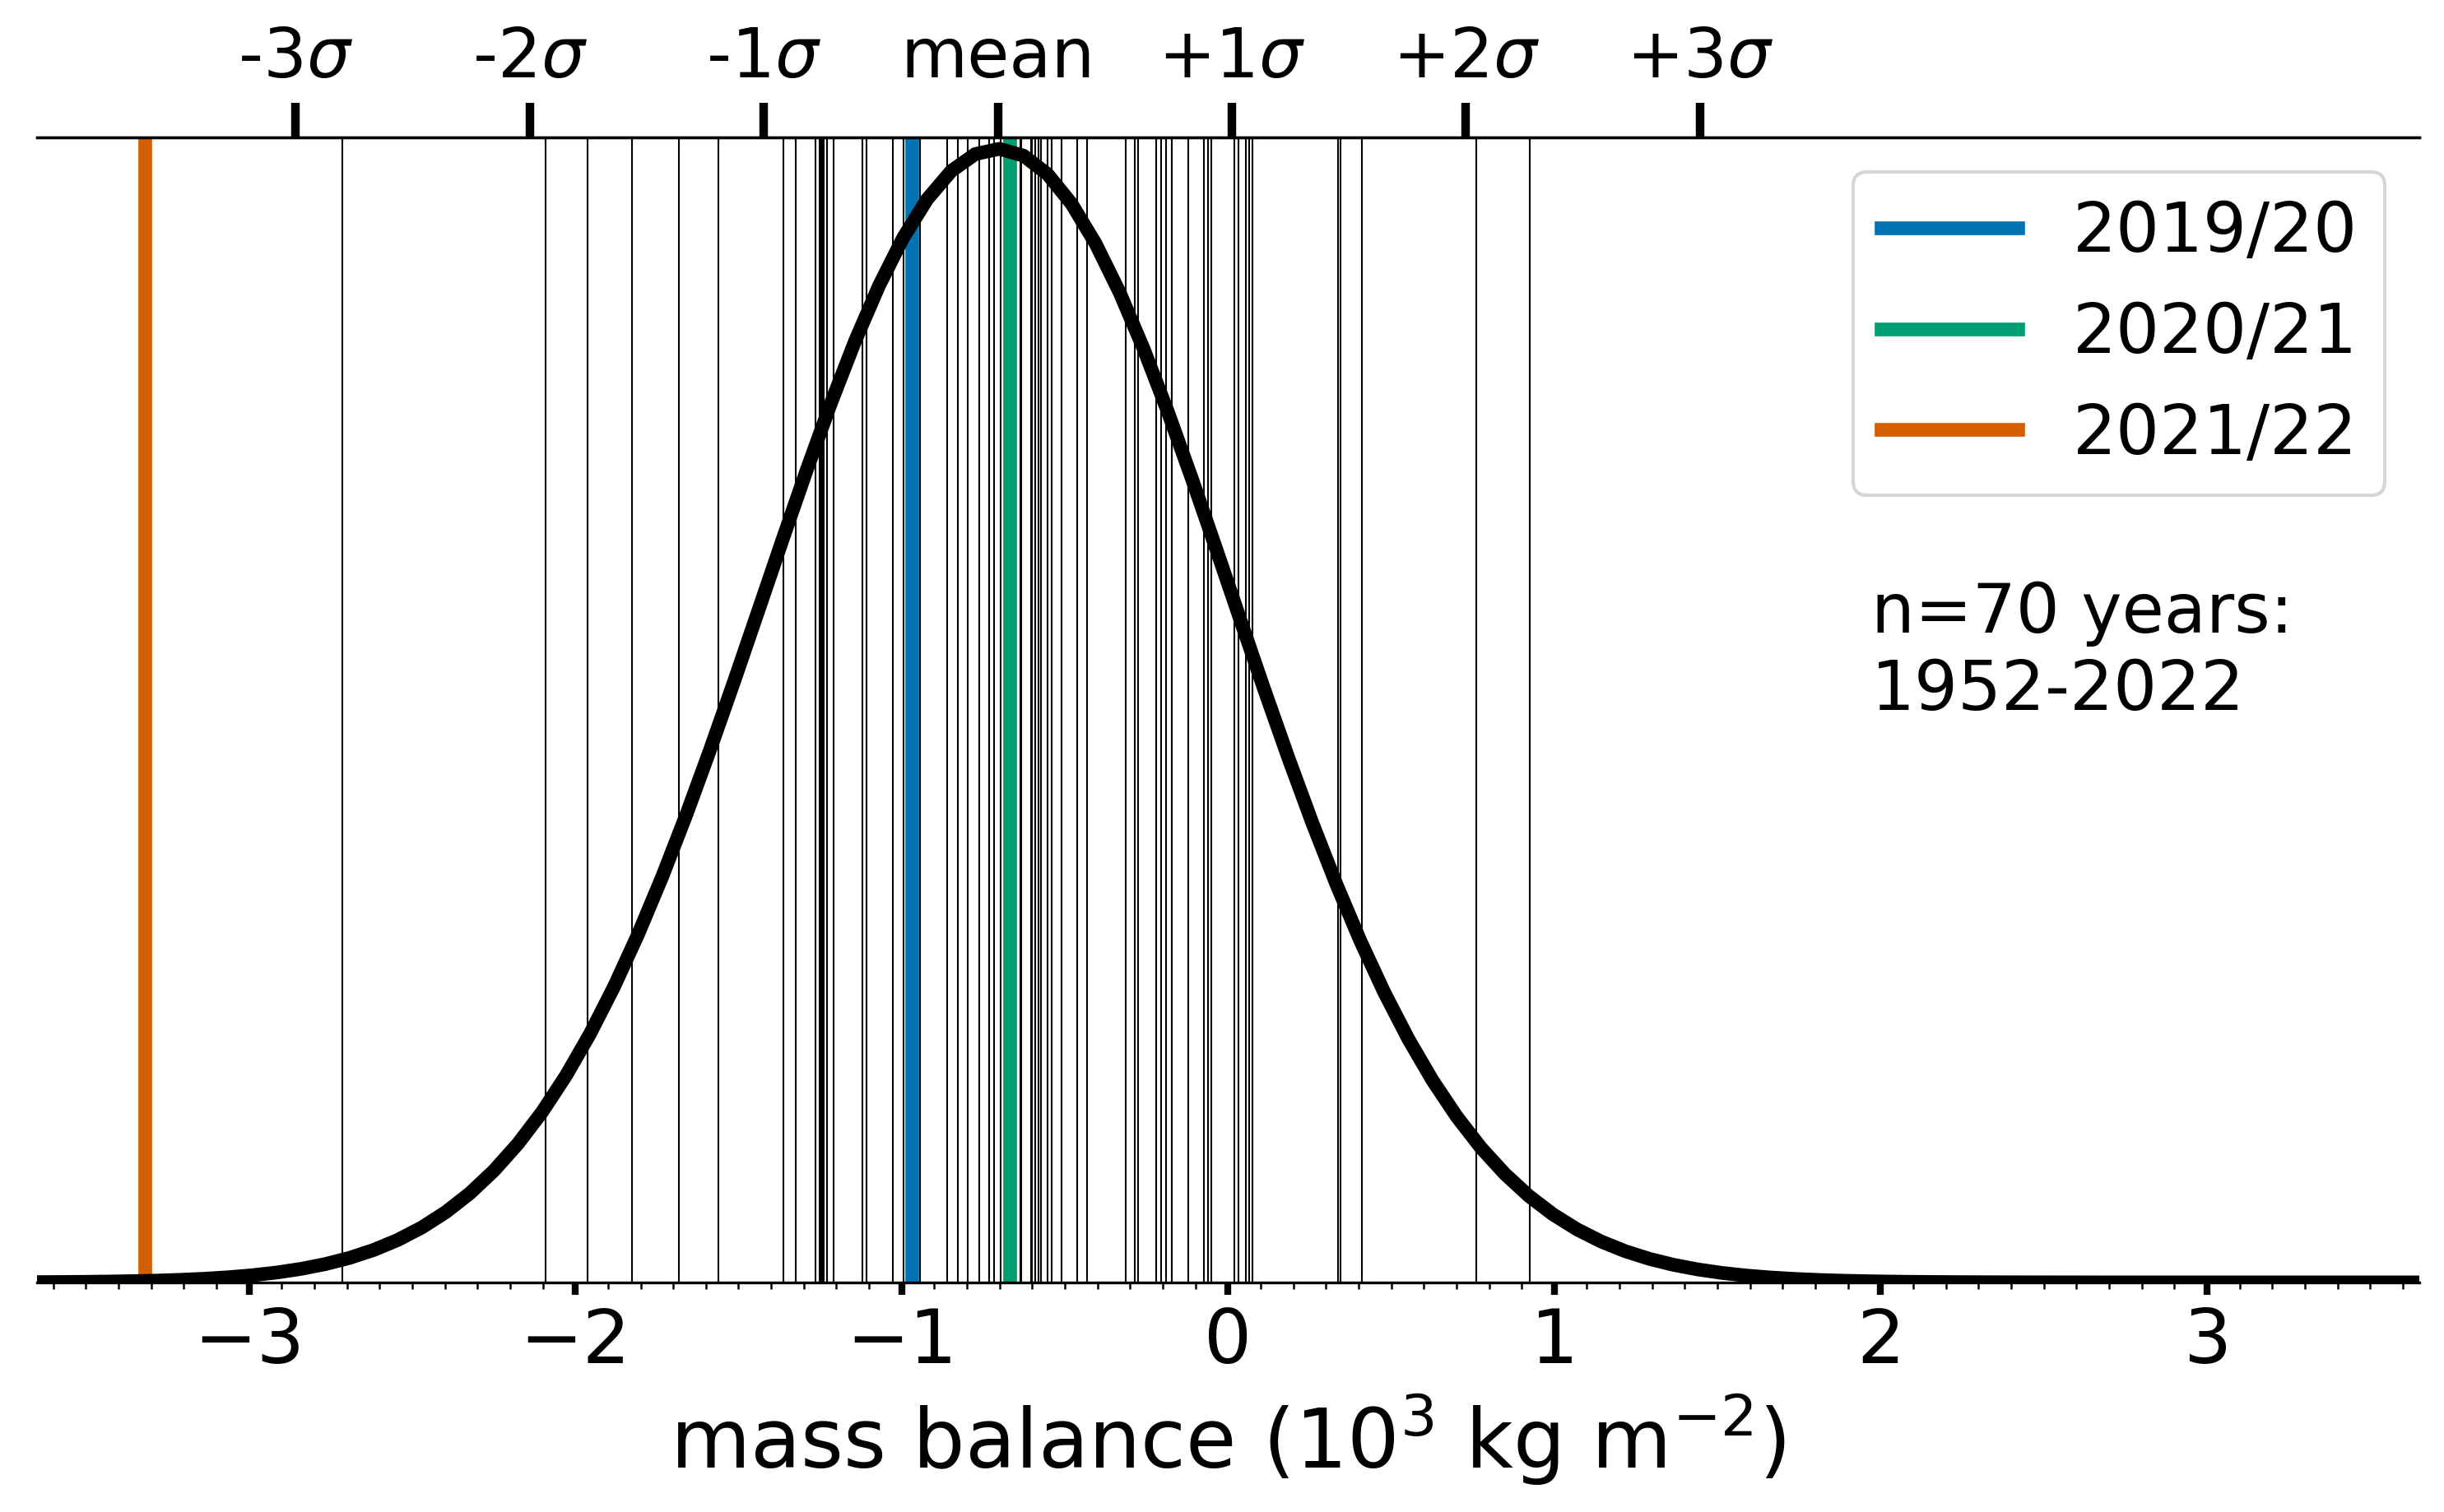

In [10]:
version = 'tc'
for save in ['save_png', 'save_pdf_svg']:
    # the arrow - line connections to display the ranges somehow work differently if saved as png or as pdf svg, therefore I need different numbers to get "similar" outcomes
    if save == 'save_png':
        armB = 150
    elif save == 'save_pdf_svg':
        armB = 45
    arrowprops = {"arrowstyle":"-", "color":"gray", "connectionstyle":f"arc,angleA=0,angleB=90,armA=0,armB={armB},rad=30", "lw":2}
    for glacier in ['Hintereisferner']: 
        # the test "glacier lost mass" and "..gained mass", needs different y-location depending on the glacier scale
        # this is adapted here, could be automated if you want to do it on other glaciers ... 
        if glacier == 'Hintereisferner':
            y_span_text_m = 0.18
        else:
            y_span_text_m = 0.22
        if glacier == 'Hintereisferner':
            spec_mb_values = spec_mb['HEF mass balance (kg/m�)']/1000 # use 10**3 kg m-2 
        elif glacier == 'Kesselwandferner':
            spec_mb_values = spec_mb['KWF mass balance (kg/m�)']/1000 # use 10**3 kg m-2 

        # get maximum specific mb and use them as limits for the plots and for the colormap scales 
        # we center the mass balance at 0, hence we just get the maximum absolute value 
        xlims_abs = np.max([np.absolute(spec_mb_values.max()),
                np.absolute(spec_mb_values.min())])*1.1
        if version == 'advanced':
            # for the blue-red colormap (only necessary for advanced version)
            # that is centered at MB = 0
            # normalize item number values to colormap
            # strongest color for the maximum absolute MB
            norm_col = matplotlib.colors.Normalize(vmin=-np.max([np.absolute(spec_mb_values.max()), 
                                                                 np.absolute(spec_mb_values.min())]),
                                                   vmax=np.max([np.absolute(spec_mb_values.max()), 
                                                                np.absolute(spec_mb_values.min())]))

        fig,_ = plt.subplots(1,1,figsize=(10,6))
        fig.set_dpi(300)

        # plot each year as vertical line 
        for j, yr in enumerate(spec_mb.index):
            if yr in [2020,2021,2022]:
                color = col_sp_yr[yr]
                lw=4
                plt.axvline(spec_mb_values.loc[yr], color = color, lw=lw, label =f'{yr-1}/{str(yr)[2:]}')

            else:
                color = 'black'
                lw = 0.5
                plt.axvline(spec_mb_values.loc[yr], color = color, lw=lw)
        plt.legend(fontsize=20)

        plt.xlim([-xlims_abs, xlims_abs])

        # fit and plot the gaussian distribution (fitted from the observations)
        # get mean and std of the observed specific mb values
        mean, std = norm.fit(spec_mb_values)
        xmin, xmax = -xlims_abs,xlims_abs
        x = np.linspace(xmin, xmax, 100)
        y = norm.pdf(x, mean, std)
        plt.plot(x, y, lw=4, color='black')

        # check if a year is "extreme" (outside the mean +/- 2std or mean +/- 3 std)
        # if this is true, draw the vertical line bigger and in color (depending on if it is a positive or negative extreme)
        # horizontal displacement of year text                

        plt.xlabel(r'mass balance (10$^{3}$ kg m$^{-2}$)', fontsize=24) #, fontweight='bold')
        #plt.title(f'{glacier} \n \n', fontsize=24, fontweight='bold')
        ax = plt.gca()
        ax.set_xticks(np.arange(-int(xlims_abs)-1, int(xlims_abs)+1.01,0.1), minor=True)
        plt.xticks(ticks=np.arange(-int(xlims_abs), int(xlims_abs)+0.01,1), fontsize=22) #, fontweight='bold')#, width=2)
        ax.tick_params(axis='x', which='major', labelsize=22, width=2) #,fontweight='bold') #, width=2.5, length=10)

        plt.xlim([-xlims_abs, xlims_abs])

        plt.text(0.77, 0.5,
                 f'n={len(spec_mb_values)} years:\n1952-2022', 
                 #rotation=90,
                 transform=plt.gca().transAxes, fontsize=20) #, fontweight='bold')

        # create secondary axis and plot the quantiles 
        ax2 = ax.secondary_xaxis(location='top')
        # create random values and then compute the quantiles to get the 90% and 99%-range
        #gauss_dis_random_vals=np.random.normal(loc=mean, scale=std, size=100000)
        #q005,q05,q95,q995 = np.quantile(gauss_dis_random_vals, q=[0.005, 0.05,0.95,0.995])
        # annotate the -3 to 3 sigma:

        ax2.set_xticks([mean-3*std,mean-2*std,mean-1*std,mean,mean+1*std,mean+2*std,mean+3*std])
        ax2.set_xticklabels(labels= [r'-3$\sigma$',r'-2$\sigma$',r'-1$\sigma$',
                                     r'mean',r'+1$\sigma$', r'+2$\sigma$', r'+3$\sigma$']) # , fontweight='bold', fontsize=16)
        ax2.set_zorder(2)
        #if version=='advanced':
        # draw the range line to make clearer that this represents the 99%-range & 90% range ...

        # remove yticks
        plt.yticks(ticks=[])
        #remove yline axis
        ax.spines['left'].set_linewidth(0)
        ax.spines['right'].set_linewidth(0)
        # make sure that 0 "probability" is directly on the x-axis
        plt.ylim([0,y.max()*1.01])

        # make spans over mean +/-1std and mean +/-2std
        #plt.axvspan(mean-std, mean+std, color='grey', alpha = 0.3)
        #plt.axvspan(mean-2*std, mean+2*std, color='grey', alpha = 0.1)

        #if save=='save_png':
        plt.tight_layout()
        # set the parameters for both axis: label size in font points, the line tick line width and length in pixels
        ax2.tick_params(axis='x', which='major', labelsize=20, width=2.5, length=10)


        if glacier == 'Hintereisferner':
            if save=='save_png':
                plt.savefig(f'hef_mb_distributions_{version}.png', bbox_inches='tight')
            else:
                plt.savefig(f'hef_mb_distributions_{version}.svg', bbox_inches='tight')
                plt.savefig(f'hef_mb_distributions_{version}.pdf', bbox_inches='tight')

        if save == 'save_pdf_svg':
            plt.close()